# Python Machine Learning Strategies for Predicting Bitcoin Price Fluctuations

### Abstract

The predictive accuracy of Bitcoin price direction using machine learning methods, focusing on the unique challenges presented by its volatility and transient market status. While existing literature has extensively explored various machine learning techniques for time series prediction, research specifically targeting Bitcoin remains limited. Given Bitcoin's performance as a top-performing currency in recent years, this study aims to fill this gap and highlight the potential for profitable trading strategies. Additionally, the research examines the advantages of utilizing GPU-based machine learning algorithms over traditional CPU methods, demonstrating significant performance improvements. By analyzing key dependent variables and assessing their importance through various regression algorithms, this study seeks to contribute valuable insights to the field of cryptocurrency prediction and inform trading practices in this dynamic market.


# Dataset Explanation

The dataset contains financial and auxiliary data used for predicting Bitcoin's closing prices using deep learning models. Below is a detailed explanation of the columns:

## Timestamp
- **Description:** The time at which the data was recorded.
- **Format:** Unix timestamp or ISO 8601 datetime format.

## Bitcoin Features (BTCUSDT)
- **open_BTCUSDT:** The opening price of Bitcoin against Tether for the given time interval.
- **high_BTCUSDT:** The highest price of Bitcoin against Tether during the time interval.
- **low_BTCUSDT:** The lowest price of Bitcoin against Tether during the time interval.
- **close_BTCUSDT:** The closing price of Bitcoin against Tether. This is the **target variable** for prediction.
- **volume_BTCUSDT:** The trading volume of Bitcoin against Tether during the time interval.

## Supporting Cryptocurrency Features
### Litecoin (LTCUSD)
- **close_LTCUSD:** The closing price of Litecoin against the US Dollar.
- **volume_LTCUSD:** The trading volume of Litecoin against the US Dollar.

### Ethereum (ETHUSD)
- **close_ETHUSD:** The closing price of Ethereum against the US Dollar.
- **volume_ETHUSD:** The trading volume of Ethereum against the US Dollar.

## Auxiliary Data Columns (News Sentiment and Analytics)
These columns provide data extracted from news sites, which can serve as additional input features for the model to improve predictions.

### Google News Features
- **gnews_flair:** Numeric data reflecting trends or mentions related to Bitcoin from Google News articles.
- **gnews_tb_polarity:** A numeric value reflecting the overall polarity (positive/negative) from Google News data.
- **gnews_tb_subjectivity:** A numeric value representing the subjectivity of Google News articles.
- **gnews_sid_pos:** Fraction of positive sentiment in Google News data.
- **gnews_sid_neg:** Fraction of negative sentiment in Google News data.
- **gnews_sid_neu:** Fraction of neutral sentiment in Google News data.
- **gnews_sid_com:** Compound sentiment score derived from Google News data.

### Reddit Features
- **reddit_flair:** Numeric data reflecting trends or mentions related to Bitcoin from Reddit discussions.
- **reddit_tb_polarity:** A numeric value reflecting the overall polarity (positive/negative) from Reddit data.
- **reddit_tb_subjectivity:** A numeric value representing the subjectivity of Reddit posts.
- **reddit_sid_pos:** Fraction of positive sentiment in Reddit discussions.
- **reddit_sid_neg:** Fraction of negative sentiment in Reddit discussions.
- **reddit_sid_neu:** Fraction of neutral sentiment in Reddit discussions.
- **reddit_sid_com:** Compound sentiment score derived from Reddit data.

## Key Points
- **Objective:** Use deep learning to predict the `close_BTCUSDT` values (Bitcoin closing prices).
- **Target Variable:** `close_BTCUSDT`.
- **Features Used:** All columns, including auxiliary data from Google News and Reddit, as input for the deep learning model.
- **Purpose:** Incorporate time-series cryptocurrency data and news trends to enhance the prediction accuracy of Bitcoin's closing price.

By combining cryptocurrency market data with auxiliary data sourced from news platforms and social media, the model aims to capture both financial and contextual influences on Bitcoin's price movements.


#### Importing libraries

In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
# from tensorflow.keras import layers
# import csv
import joblib
from datetime import datetime
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Input, Attention, Concatenate, Bidirectional
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor


Reading dataset from csv file 

In [4]:
df = pd.read_csv("crypto_data_news_reddit_final.csv")
df = pd.DataFrame(df)
len(df["timestamp"])

16536

In [12]:
df.describe()

,open_BTCUSDT,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,gnews_flair,...,gnews_sid_neg,gnews_sid_neu,gnews_sid_com,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com
count,16536.000000,16536.000000,16536.000000,16536.00000,16536.000000,16536.000000,16536.000000,16536.000000,16536.000000,16536.000000,...,16536.000000,16536.000000,16536.000000,16536.000000,16536.000000,16536.000000,16536.000000,16536.000000,16536.000000,16536.000000
mean,7448.105542,7487.309521,7405.240003,7447.76324,147.792307,90.994419,263.145839,342.149266,1218.905495,0.008095,...,0.037692,0.866189,0.479082,0.167779,0.080984,0.286732,0.094584,0.049188,0.823027,0.130858
std,2603.846248,2627.945875,2576.337269,2603.38412,228.070777,50.583023,587.143958,263.899826,2314.189065,0.338805,...,0.016052,0.035185,0.244451,0.508240,0.126679,0.172873,0.077636,0.057417,0.176192,0.239510
min,3140.230000,3155.020000,3126.880000,3140.23000,0.000000,22.320000,0.000000,81.150000,0.000000,-0.989737,...,0.000000,0.752444,-0.287989,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-0.989500
25%,5725.575000,5748.877500,5700.355000,5725.57500,29.065140,56.000000,5.134087,170.397500,176.493197,-0.237255,...,0.027222,0.846333,0.328856,-0.103949,0.000000,0.175483,0.040333,0.000000,0.795787,0.000000
50%,7419.730000,7450.000000,7379.995000,7419.73000,75.461303,75.300000,58.100000,218.125000,504.235777,0.046784,...,0.036889,0.867778,0.495167,0.171661,0.064184,0.279167,0.084333,0.034464,0.854000,0.111861
75%,9235.872500,9280.440000,9185.877500,9235.72750,176.611045,118.450000,252.582500,465.040000,1322.464127,0.269804,...,0.046556,0.888667,0.647622,0.499732,0.141323,0.392941,0.133600,0.074667,0.907167,0.262962
max,17175.000000,17236.460000,17092.710000,17175.00000,4277.891500,303.000000,13329.490000,1417.540000,76871.472784,0.994635,...,0.172667,1.000000,0.981600,1.000000,1.000000,1.000000,0.886000,0.677000,1.000000,0.999600


In [13]:
# Check for null values
print(df.isnull())  # Shows where the null values are

# Check if any value is null
print(df.isnull().any().any())  # True if any value is null

# Column-wise count of null values
print(df.isnull().sum())  # Shows number of nulls per column

# Rows with any null values
print(df[df.isnull().any(axis=1)])  # Displays rows with null values


       timestamp  open_BTCUSDT  high_BTCUSDT  low_BTCUSDT  close_BTCUSDT  \
0          False         False         False        False          False   
1          False         False         False        False          False   
2          False         False         False        False          False   
3          False         False         False        False          False   
4          False         False         False        False          False   
...          ...           ...           ...          ...            ...   
16531      False         False         False        False          False   
16532      False         False         False        False          False   
16533      False         False         False        False          False   
16534      False         False         False        False          False   
16535      False         False         False        False          False   

       volume_BTCUSDT  close_LTCUSD  volume_LTCUSD  close_ETHUSD  \
0               Fal

In [14]:
df_cleaned = df.dropna()
df_cleaned

,timestamp,open_BTCUSDT,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,...,gnews_sid_neg,gnews_sid_neu,gnews_sid_com,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com
0,2018-01-01 00:00:00,13820.26,13820.26,13498.05,13557.88,210.213142,222.24,590.23000,728.77,625.293831,...,0.025222,0.909556,0.624667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2018-01-01 01:00:00,13557.88,13585.66,13250.50,13262.85,191.931776,215.20,698.36000,724.27,710.891607,...,0.025222,0.909556,0.624667,-0.267228,0.046199,0.257910,0.105625,0.091875,0.802500,0.181325
2,2018-01-01 02:00:00,13262.85,13400.00,13186.02,13320.00,169.456410,215.36,464.55000,722.11,849.257651,...,0.025222,0.909556,0.624667,-0.300781,-0.077217,0.273153,0.032000,0.019333,0.948667,0.330133
3,2018-01-01 03:00:00,13320.00,13515.44,13308.54,13372.00,80.455327,219.30,407.81000,733.19,556.397003,...,0.025222,0.909556,0.624667,0.082537,0.242468,0.404416,0.156286,0.025000,0.818714,0.280143
4,2018-01-01 04:00:00,13372.00,13499.83,13279.50,13483.06,127.212610,223.72,965.39000,738.59,1247.722800,...,0.025222,0.909556,0.624667,0.443654,0.235317,0.321429,0.153143,0.005143,0.841714,0.341757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16531,2019-11-20 19:00:00,8099.26,8109.92,8077.82,8086.65,1.910237,54.68,26.89869,174.40,22.319940,...,0.045111,0.864333,0.457411,0.328284,0.142630,0.506278,0.110429,0.049857,0.839857,0.092543
16532,2019-11-20 20:00:00,8083.19,8111.17,8081.72,8102.66,9.783435,55.06,21.18500,174.45,25.050680,...,0.045111,0.864333,0.457411,0.000208,0.375000,0.500000,0.314500,0.000000,0.685500,0.511350
16533,2019-11-20 21:00:00,8096.06,8111.25,8078.80,8098.29,1.726209,55.10,16.47622,175.48,32.281160,...,0.045111,0.864333,0.457411,0.187590,-0.077778,0.144444,0.000000,0.157500,0.842500,-0.248400
16534,2019-11-20 22:00:00,8097.40,8113.96,8084.94,8091.13,1.683230,54.90,35.17709,174.72,5.926510,...,0.045111,0.864333,0.457411,0.996935,0.050000,0.191667,0.252000,0.000000,0.748000,0.401900


In [15]:
# Check for null values
print(df_cleaned.isnull())  # Shows where the null values are

# Check if any value is null
print(df_cleaned.isnull().any().any())  # True if any value is null

# Column-wise count of null values
print(df_cleaned.isnull().sum())  # Shows number of nulls per column

# Rows with any null values
print(df_cleaned[df_cleaned.isnull().any(axis=1)])  # Displays rows with null values

       timestamp  open_BTCUSDT  high_BTCUSDT  low_BTCUSDT  close_BTCUSDT  \
0          False         False         False        False          False   
1          False         False         False        False          False   
2          False         False         False        False          False   
3          False         False         False        False          False   
4          False         False         False        False          False   
...          ...           ...           ...          ...            ...   
16531      False         False         False        False          False   
16532      False         False         False        False          False   
16533      False         False         False        False          False   
16534      False         False         False        False          False   
16535      False         False         False        False          False   

       volume_BTCUSDT  close_LTCUSD  volume_LTCUSD  close_ETHUSD  \
0               Fal

In [16]:
df_cleaned.describe()

,open_BTCUSDT,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,gnews_flair,...,gnews_sid_neg,gnews_sid_neu,gnews_sid_com,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com
count,16536.000000,16536.000000,16536.000000,16536.00000,16536.000000,16536.000000,16536.000000,16536.000000,16536.000000,16536.000000,...,16536.000000,16536.000000,16536.000000,16536.000000,16536.000000,16536.000000,16536.000000,16536.000000,16536.000000,16536.000000
mean,7448.105542,7487.309521,7405.240003,7447.76324,147.792307,90.994419,263.145839,342.149266,1218.905495,0.008095,...,0.037692,0.866189,0.479082,0.167779,0.080984,0.286732,0.094584,0.049188,0.823027,0.130858
std,2603.846248,2627.945875,2576.337269,2603.38412,228.070777,50.583023,587.143958,263.899826,2314.189065,0.338805,...,0.016052,0.035185,0.244451,0.508240,0.126679,0.172873,0.077636,0.057417,0.176192,0.239510
min,3140.230000,3155.020000,3126.880000,3140.23000,0.000000,22.320000,0.000000,81.150000,0.000000,-0.989737,...,0.000000,0.752444,-0.287989,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-0.989500
25%,5725.575000,5748.877500,5700.355000,5725.57500,29.065140,56.000000,5.134087,170.397500,176.493197,-0.237255,...,0.027222,0.846333,0.328856,-0.103949,0.000000,0.175483,0.040333,0.000000,0.795787,0.000000
50%,7419.730000,7450.000000,7379.995000,7419.73000,75.461303,75.300000,58.100000,218.125000,504.235777,0.046784,...,0.036889,0.867778,0.495167,0.171661,0.064184,0.279167,0.084333,0.034464,0.854000,0.111861
75%,9235.872500,9280.440000,9185.877500,9235.72750,176.611045,118.450000,252.582500,465.040000,1322.464127,0.269804,...,0.046556,0.888667,0.647622,0.499732,0.141323,0.392941,0.133600,0.074667,0.907167,0.262962
max,17175.000000,17236.460000,17092.710000,17175.00000,4277.891500,303.000000,13329.490000,1417.540000,76871.472784,0.994635,...,0.172667,1.000000,0.981600,1.000000,1.000000,1.000000,0.886000,0.677000,1.000000,0.999600


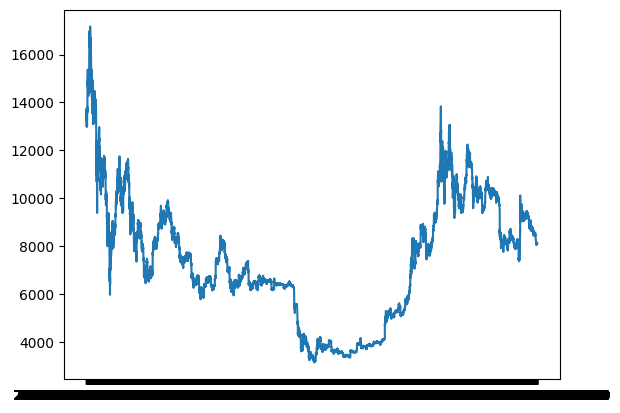

In [17]:
# df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
df_cleaned= df_cleaned.reset_index(drop=True)
plt.plot(df_cleaned['timestamp'], df_cleaned['close_BTCUSDT'])
plt.show()
# print(df_cleaned['timestamp'].shape, df_cleaned['close_BTCUSDT'].shape)


In [13]:
df_corr=df_cleaned.drop('timestamp',axis=1)
correlation_matrix = df_corr.corr()
correlation_matrix

,open_BTCUSDT,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,gnews_flair,...,gnews_sid_neg,gnews_sid_neu,gnews_sid_com,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com
open_BTCUSDT,1.000000,0.999727,0.999628,0.999548,0.077192,0.727095,0.242567,0.589551,0.033483,0.091166,...,-0.020508,-0.188786,0.060728,-0.023960,-0.010963,-0.014330,-0.000542,0.029257,0.045975,-0.022789
high_BTCUSDT,0.999727,1.000000,0.999429,0.999755,0.086924,0.729840,0.249149,0.592657,0.040007,0.091612,...,-0.019084,-0.189252,0.059272,-0.024274,-0.011125,-0.014250,-0.000406,0.029704,0.046287,-0.022866
low_BTCUSDT,0.999628,0.999429,1.000000,0.999726,0.063102,0.724486,0.232875,0.586072,0.023251,0.090205,...,-0.022651,-0.188335,0.063043,-0.024201,-0.010575,-0.014191,-0.000263,0.028906,0.045723,-0.022227
close_BTCUSDT,0.999548,0.999755,0.999726,1.000000,0.075342,0.727496,0.241394,0.589498,0.031669,0.091083,...,-0.020885,-0.188925,0.061267,-0.024336,-0.010772,-0.014134,-0.000219,0.029254,0.045970,-0.022330
volume_BTCUSDT,0.077192,0.086924,0.063102,0.075342,1.000000,0.220817,0.538027,0.270301,0.642588,0.050387,...,0.112161,-0.028105,-0.087845,-0.001607,-0.018741,-0.006572,-0.008528,0.036847,0.028163,-0.028527
close_LTCUSD,0.727095,0.729840,0.724486,0.727496,0.220817,1.000000,0.418514,0.892820,0.140016,0.046191,...,-0.031193,-0.070471,0.046194,-0.010553,-0.023451,-0.039663,-0.001091,0.043570,0.067247,-0.049256
volume_LTCUSD,0.242567,0.249149,0.232875,0.241394,0.538027,0.418514,1.000000,0.396583,0.430161,0.035941,...,0.048726,-0.043512,-0.042510,-0.005234,-0.019331,-0.013713,-0.013806,0.032868,0.032569,-0.040864
close_ETHUSD,0.589551,0.592657,0.586072,0.589498,0.270301,0.892820,0.396583,1.000000,0.185097,0.044667,...,0.049315,-0.012873,0.014646,0.002106,-0.024998,-0.042366,0.000037,0.051895,0.075227,-0.056177
volume_ETHUSD,0.033483,0.040007,0.023251,0.031669,0.642588,0.140016,0.430161,0.185097,1.000000,0.054784,...,0.085484,-0.004065,-0.079361,-0.000025,-0.015650,-0.001288,-0.009786,0.037454,0.028642,-0.029483
gnews_flair,0.091166,0.091612,0.090205,0.091083,0.050387,0.046191,0.035941,0.044667,0.054784,1.000000,...,0.108400,-0.382542,0.243417,0.010500,0.005963,0.014074,-0.000970,0.004984,0.025968,-0.008429


Epoch 1/150


C:\Users\Rupak Nalla\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


414/414 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 47576184.0000
Epoch 2/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3756734.2500
Epoch 3/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2267026.2500
Epoch 4/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1210967.8750
Epoch 5/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1062544.7500
Epoch 6/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 920498.3750
Epoch 7/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 878239.8750
Epoch 8/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 852269.6875
Epoch 9/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 845884.8750
Epoch 10/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 851987.7500
Epoch 11/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 803170.5625
Epoch 12/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 822596.2500
Epoch 13/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 793245.8750
Epoch 14/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

C:\Users\Rupak Nalla\AppData\Roaming\Python\Python312\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


414/414 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 53780036.0000
Epoch 2/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 53759776.0000
Epoch 3/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 53113036.0000
Epoch 4/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 54132700.0000
Epoch 5/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 53863632.0000
Epoch 6/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 53339336.0000
Epoch 7/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 53211336.0000
Epoch 8/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 52957728.0000
Epoch 9/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 52622980.0000
Epoch 10/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 52795088.0000
Epoch 11/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 53153360.0000
Epoch 12/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 51978520.0000
Epoch 13/150
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 52631312.0000
Epoch 14/150
414/414 ━━━━━━━━━━━━

C:\Users\Rupak Nalla\AppData\Roaming\Python\Python312\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
RMSE: 161.96268993233323
R²: 0.9808985131032164


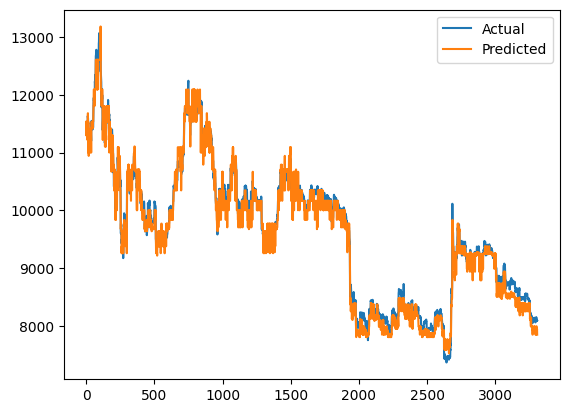

In [32]:

# Preprocess data
def preprocess_data(data):
    X = data.drop(columns=['close_BTCUSDT','timestamp'])
    y = data['close_BTCUSDT']

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler

# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Build Attention-LSTM model
def build_attention_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    lstm = LSTM(64, return_sequences=True)(inputs)
    attention_output = Attention()([lstm, lstm])
    lstm_out = LSTM(32)(attention_output)
    output = Dense(1)(lstm_out)
    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Train ARIMA model
def train_arima_model(train_data):
    arima_model = ARIMA(train_data, order=(5, 1, 0))
    arima_fit = arima_model.fit()
    return arima_fit

# Evaluate and visualize predictions
def evaluate_and_visualize(y_test, final_preds):
    rmse = np.sqrt(mean_squared_error(y_test, final_preds))
    r2 = r2_score(y_test, final_preds)
    print(f"RMSE: {rmse}")
    print(f"R²: {r2}")

    import matplotlib.pyplot as plt
    plt.plot(y_test.values, label='Actual')
    plt.plot(final_preds, label='Predicted')
    plt.legend()
    plt.show()

# Load your dataset
data = df_cleaned  # Replace with your dataset file

# Preprocess data
X, y, scaler = preprocess_data(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape for LSTM models
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Train LSTM model
lstm_model = build_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))
lstm_model.fit(X_train_lstm, y_train, epochs=150, batch_size=32, verbose=1)

# Train ARIMA model
arima_model = train_arima_model(y_train)

# Train Attention-LSTM model
attention_lstm_model = build_attention_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))
attention_lstm_model.fit(X_train_lstm, y_train, epochs=150, batch_size=32, verbose=1)

# Predictions from individual models
lstm_train_preds = lstm_model.predict(X_train_lstm)
arima_train_preds = arima_model.predict(start=0, end=len(y_train)-1)
attention_lstm_train_preds = attention_lstm_model.predict(X_train_lstm)

# Stack predictions for meta-model training
stacked_train_preds = np.column_stack((lstm_train_preds, arima_train_preds, attention_lstm_train_preds))

# Train meta-model (XGBoost)
meta_model = XGBRegressor()

meta_model.fit(stacked_train_preds, y_train)

# Predictions on test data
lstm_test_preds = lstm_model.predict(X_test_lstm)
arima_test_preds = arima_model.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)
attention_lstm_test_preds = attention_lstm_model.predict(X_test_lstm)

# Stack test predictions
stacked_test_preds = np.column_stack((lstm_test_preds, arima_test_preds, attention_lstm_test_preds))

# Meta-model final predictions
final_preds = meta_model.predict(stacked_test_preds)

# Evaluate and visualize
evaluate_and_visualize(y_test, final_preds)


Checking for best model

In [ ]:

# Evaluate and save the best model based on RMSE or R²
def compare_and_save_best_model(models, model_names, y_test, predictions):
    best_rmse = float('inf')
    best_model = None
    best_model_name = ""
    
    # Track the best model
    for model, model_name, prediction in zip(models, model_names, predictions):
        rmse = np.sqrt(mean_squared_error(y_test, prediction))
        print(f"{model_name} - RMSE: {rmse}")

        # Compare to find the best model based on RMSE
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_model_name = model_name

    # Save the best model
    print(f"The best performing model is: {best_model_name}")
    joblib.dump(best_model, f'best_model_{best_model_name}.pkl')  # Save the best model

# Predictions from individual models (You have already calculated these)
lstm_test_preds = lstm_model.predict(X_test_lstm)
arima_test_preds = arima_model.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)
attention_lstm_test_preds = attention_lstm_model.predict(X_test_lstm)
meta_model_test_preds = meta_model.predict(stacked_test_preds)

# Collect models, model names, and their predictions
models = [lstm_model, arima_model, attention_lstm_model, meta_model]
model_names = ['LSTM', 'ARIMA', 'Attention-LSTM', 'Meta-Model (XGBoost)']
predictions = [lstm_test_preds, arima_test_preds, attention_lstm_test_preds, meta_model_test_preds]

# Compare models and save the best one
compare_and_save_best_model(models, model_names, y_test, predictions)


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
LSTM - RMSE: 205.0449756381008
ARIMA - RMSE: 2190.341152058975
Attention-LSTM - RMSE: 8178.272644601699
Meta-Model (XGBoost) - RMSE: 161.96268993233323
The best performing model is: Meta-Model (XGBoost)


Checking model on input

In [49]:
# Function to preprocess input for individual models
def preprocess_for_lstm(data):
    """
    Preprocess input data for LSTM-based models.
    Args:
        data (np.array): Sequential input data.

    Returns:
        np.array: Reshaped data for LSTM input.
    """
    return data.reshape(1, data.shape[0], data.shape[1])

def preprocess_for_arima(data):
    """
    Preprocess input data for ARIMA.
    Args:
        data (np.array): Time series data.

    Returns:
        np.array: Single time series for ARIMA.
    """
    return data.flatten()

# Function to make a single prediction
def predict_with_ensemble(input_data):
    """
    Predict BTC closing price using the ensemble of models.
    Args:
        input_data (np.array): Input feature array.

    Returns:
        float: Final predicted closing price.
    """
    scaled_data = scaler.transform(input_data)
    lstm_input = preprocess_for_lstm(scaled_data)
    arima_input = preprocess_for_arima(scaled_data)
    attention_lstm_input = preprocess_for_lstm(scaled_data)
    lstm_preds = lstm_model.predict(lstm_input)
    arima_preds = arima_model.predict(start=0, end=0)  # Adjust ARIMA predict params as needed
    attention_lstm_preds = attention_lstm_model.predict(attention_lstm_input)
    stacked_preds = np.column_stack((lstm_preds, arima_preds, attention_lstm_preds))
    final_preds = meta_model.predict(stacked_preds)
    return final_preds[0]

input_data = np.array([
    [13820.26, 13950.00, 13780.00, 13850.00, 120.5, 70.3, 1800.5, 0.5, 0.8, 0.2, 0.6, 0.1, 0.3, 0.75, 0.2, 0.05, 0.7, 0.8, 0.1, 0.4, 0.2, 0.6]
])

# Predict
predicted_price = predict_with_ensemble(input_data)

# Output
print(f"Predicted BTC Closing Price: {predicted_price}")


C:\Users\Rupak Nalla\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Predicted BTC Closing Price: 14200.162109375
